In [30]:
import pandas as pd
import requests
from io import StringIO
import networkx as nx
import numpy as np
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

In [6]:
def load_csv_from_github(start_year, end_year):
    base_url = "https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_{}.csv"
    df_list = []

    for year in range(start_year, end_year + 1):
        url = base_url.format(year)
        response = requests.get(url)
        if response.status_code == 200:  # Check if the request was successful
            data = StringIO(response.text)
            df = pd.read_csv(data)
            df_list.append(df)
        else:
            print(f"Failed to retrieve data for year {year}")

    # Combine all DataFrames into a single DataFrame
    combined_df = pd.concat(df_list, ignore_index=True)
    return combined_df

# Load data from 1980 to 2024
atp_data = load_csv_from_github(1990, 2024)
print(atp_data.head())  # Print the first few rows of the DataFrame

  tourney_id tourney_name surface  draw_size tourney_level  tourney_date  \
0   1990-339     Adelaide    Hard         32             A      19900101   
1   1990-339     Adelaide    Hard         32             A      19900101   
2   1990-339     Adelaide    Hard         32             A      19900101   
3   1990-339     Adelaide    Hard         32             A      19900101   
4   1990-339     Adelaide    Hard         32             A      19900101   

   match_num  winner_id winner_seed winner_entry  ... l_1stIn l_1stWon  \
0          1     101843         1.0          NaN  ...     NaN      NaN   
1          2     100714         NaN           WC  ...     NaN      NaN   
2          3     101529         NaN          NaN  ...     NaN      NaN   
3          4     100628         7.0          NaN  ...     NaN      NaN   
4          5     101404         3.0          NaN  ...     NaN      NaN   

   l_2ndWon l_SvGms  l_bpSaved  l_bpFaced winner_rank winner_rank_points  \
0       NaN     NaN   

In [10]:
# Convert tourney_date to datetime
atp_data['tourney_date'] = pd.to_datetime(atp_data['tourney_date'], format='%Y%m%d')

# Create a unique identifier for each player
atp_data['player_id'] = atp_data['winner_id'].combine_first(atp_data['loser_id'])

# Get the first and last appearance for each player
player_careers = atp_data.groupby('player_id').agg({
    'tourney_date': ['min', 'max'],
    'match_num': 'count'
})

player_careers.columns = ['career_start', 'career_end', 'total_matches']
player_careers['career_length'] = (player_careers['career_end'] - player_careers['career_start']).dt.days / 365.25

In [36]:
import matplotlib
print(matplotlib.__version__)

kmf = KaplanMeierFitter()

T = player_careers['career_length']
E = np.ones(len(T))  # All events are observed (no censoring)

kmf.fit(T, E, label="Player Careers")

print(kmf)
# plt.figure(figsize=(10, 6))
# kmf.plot()
# plt.title("Kaplan-Meier Estimate of Player Career Survival")
# plt.xlabel("Years")
# plt.ylabel("Survival Probability")
# plt.grid(True)
# plt.show()

3.7.2
<lifelines.KaplanMeierFitter:"Player Careers", fitted with 2443 total observations, 0 right-censored observations>


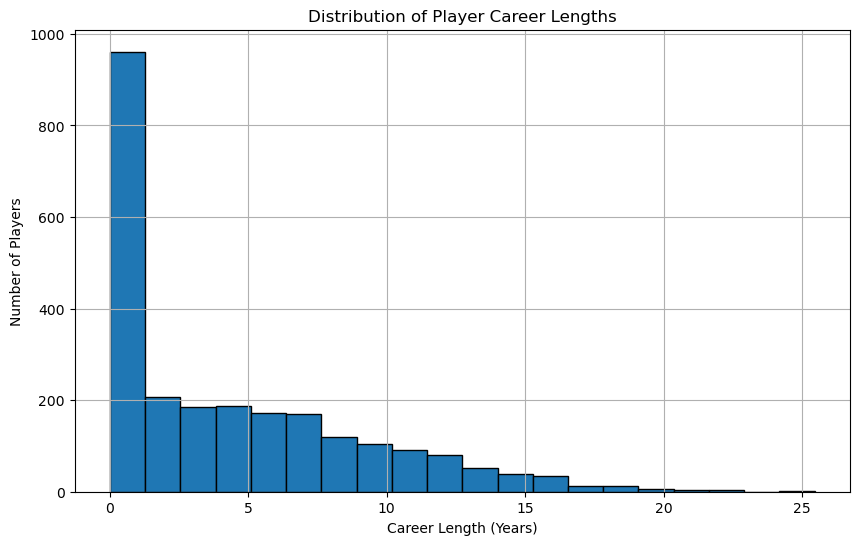

In [20]:
plt.figure(figsize=(10, 6))
plt.hist(player_careers['career_length'], bins=20, edgecolor='black')
plt.title("Distribution of Player Career Lengths")
plt.xlabel("Career Length (Years)")
plt.ylabel("Number of Players")
plt.grid(True)
plt.show()

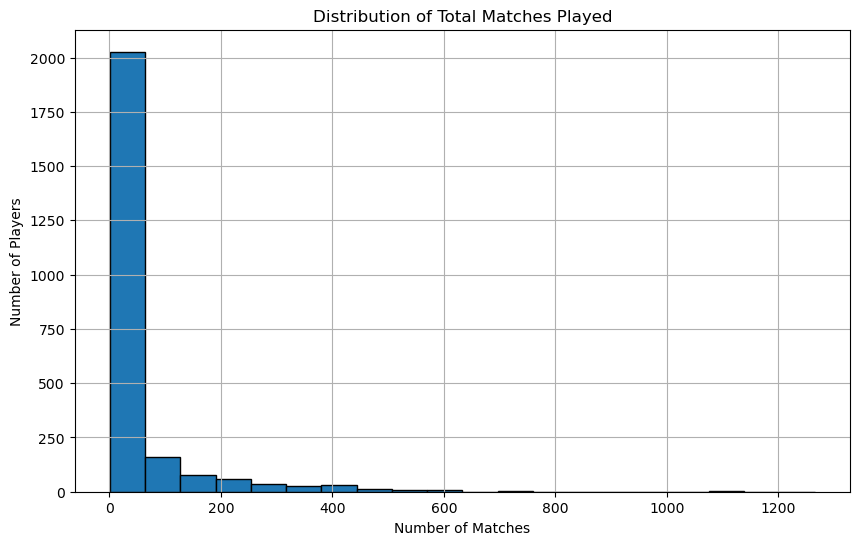

In [22]:
plt.figure(figsize=(10, 6))
plt.hist(player_careers['total_matches'], bins=20, edgecolor='black')
plt.title("Distribution of Total Matches Played")
plt.xlabel("Number of Matches")
plt.ylabel("Number of Players")
plt.grid(True)
plt.show()

In [24]:
print("Career Length Statistics:")
print(player_careers['career_length'].describe())

print("\nTotal Matches Statistics:")
print(player_careers['total_matches'].describe())

print("\nNumber of players who played for:")
print("Less than 1 year:", sum(player_careers['career_length'] < 1))
print("1-5 years:", sum((player_careers['career_length'] >= 1) & (player_careers['career_length'] < 5)))
print("5-10 years:", sum((player_careers['career_length'] >= 5) & (player_careers['career_length'] < 10)))
print("10+ years:", sum(player_careers['career_length'] >= 10))

Career Length Statistics:
count    2443.000000
mean        4.385258
std         4.732115
min         0.000000
25%         0.000000
50%         2.989733
75%         7.196441
max        25.453799
Name: career_length, dtype: float64

Total Matches Statistics:
count    2443.000000
mean       45.189112
std       104.912472
min         1.000000
25%         2.000000
50%         5.000000
75%        30.000000
max      1265.000000
Name: total_matches, dtype: float64

Number of players who played for:
Less than 1 year: 899
1-5 years: 613
5-10 years: 571
10+ years: 360
